In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance
import lime
import lime.lime_tabular
import shap


    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

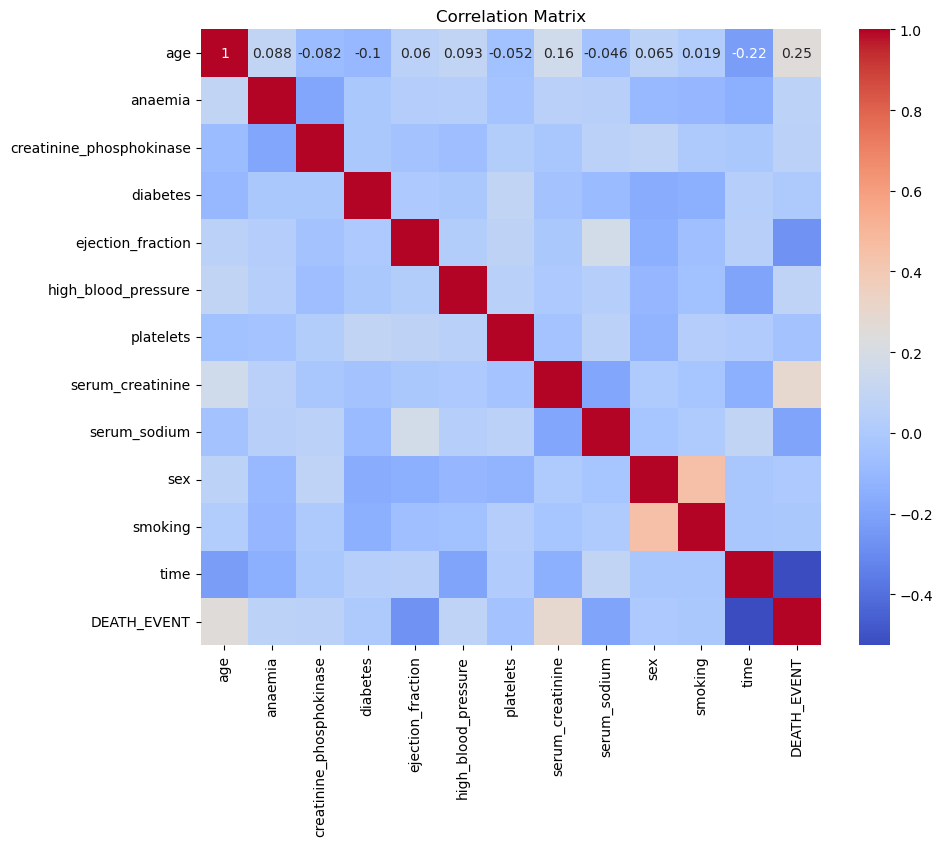

In [4]:
# Load the dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

# Overview of the dataset
print(df.head())
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [5]:
# Separate features and target
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Define hyperparameters grid for each model
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 10]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

# Perform GridSearchCV
best_models = {}
for name, model in models.items():
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc')
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best ROC-AUC score for {name}: {grid.best_score_}")


Best parameters for Logistic Regression: {'C': 1}
Best ROC-AUC score for Logistic Regression: 0.8954587895764368
Best parameters for Decision Tree: {'max_depth': 7, 'min_samples_split': 10}
Best ROC-AUC score for Decision Tree: 0.8459697818521347
Best parameters for Random Forest: {'max_depth': 5, 'n_estimators': 200}
Best ROC-AUC score for Random Forest: 0.939679993209405


In [ ]:
# Evaluate the models
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_prob)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


In [ ]:
# Logistic Regression with eli5
log_reg = best_models['Logistic Regression']
eli5.show_weights(log_reg, feature_names=X.columns.tolist())

# Decision Tree with eli5
dt = best_models['Decision Tree']
eli5.show_weights(dt, feature_names=X.columns.tolist())

# LIME explanation for Random Forest
rf = best_models['Random Forest']
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, class_names=['No', 'Yes'], discretize_continuous=True)
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test[i], rf.predict_proba)
exp.show_in_notebook(show_table=True)

# SHAP explanation for XGBoost
xgb = best_models['XGBoost']
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
shap.force_plot(explainer.expected_value, shap_values[i], X_test[i], feature_names=X.columns)


In [ ]:
# Predict using all models for a selected observation
i = np.random.randint(0, X_test.shape[0])
for name, model in best_models.items():
    y_prob = model.predict_proba([X_test[i]])[0]
    print(f"{name} prediction probabilities for selected observation: {y_prob}")
